In [1]:
#Mandatory imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [2]:
train = pd.read_json("input/train.json")
target_train=train['is_iceberg']
test = pd.read_json("input/test.json")

In [3]:
target_train=train['is_iceberg']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
train['inc_angle']=train['inc_angle'].fillna(method='pad')
X_angle=train['inc_angle']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
X_test_angle=test['inc_angle']

In [4]:
#Generate the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_band_3=(X_band_1+X_band_2)/2
#X_band_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in train["inc_angle"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis]
                          , X_band_2[:, :, :, np.newaxis]
                         , X_band_3[:, :, :, np.newaxis]], axis=-1)

In [5]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_band_test_3=(X_band_test_1+X_band_test_2)/2
#X_band_test_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in test["inc_angle"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , X_band_test_3[:, :, :, np.newaxis]], axis=-1)

In [6]:
#Import Keras.
from matplotlib import pyplot
from keras.optimizers import RMSprop
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import rmsprop
from keras.optimizers import SGD
from keras.optimizers import Nadam
from keras.optimizers import Adadelta
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [7]:
#Data Aug for multi-input
from keras.preprocessing.image import ImageDataGenerator
batch_size=64
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.2,
                         rotation_range = 10)

In [8]:
# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=55)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=55)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

In [9]:
# Finally create generator
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=10, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

In [10]:
def getVggAngleModel():
    input_2 = Input(shape=[1], name="angle")
    angle_layer = Dense(1, )(input_2)
    base_model = VGG16(weights='imagenet', include_top=False, 
                 input_shape=X_train.shape[1:], classes=1)
    x = base_model.get_layer('block5_pool').output
    

    x = GlobalMaxPooling2D()(x)
    merge_one = concatenate([x, angle_layer])
    merge_one = Dense(512, activation='relu', name='fc2')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    merge_one = Dense(512, activation='relu', name='fc3')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    
    predictions = Dense(1, activation='sigmoid')(merge_one)
    
    model = Model(inputs=[base_model.input, input_2], outputs=predictions)
    
#     adadelta= Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
#     model.compile(loss='binary_crossentropy',
#                   optimizer=adadelta,
#                   metrics=['accuracy'])
    
    sgd = SGD(lr=3e-4, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model



In [11]:
#def myAngleCV(X_train, X_angle, X_test):
K=10
folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=16).split(X_train, target_train))
y_test_pred_log = 0
y_train_pred_log=0
y_valid_pred_log = 0.0*target_train
for j, (train_idx, test_idx) in enumerate(folds):
    print('\n===================FOLD=',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = target_train[train_idx]
    X_holdout = X_train[test_idx]
    Y_holdout= target_train[test_idx]
    
    #Angle
    X_angle_cv=X_angle[train_idx]
    X_angle_hold=X_angle[test_idx]
    #define file path and get callbacks
    file_path = "%s_aug_model_weights.hdf5"%j
    callbacks = get_callbacks(filepath=file_path, patience=5)
    gen_flow = gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
    galaxyModel= getVggAngleModel()
    histr = galaxyModel.fit_generator(
            gen_flow,
            steps_per_epoch=24,
            epochs=100,
            shuffle=True,
            verbose=1,
            validation_data=([X_holdout,X_angle_hold], Y_holdout),
            callbacks=callbacks)
     #Getting the Best Model
    galaxyModel.load_weights(filepath=file_path)
    #Getting Training Score
    score = galaxyModel.evaluate([X_train_cv,X_angle_cv], y_train_cv, verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    #Getting Test Score
    score = galaxyModel.evaluate([X_holdout,X_angle_hold], Y_holdout, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    #Getting validation Score.
    pred_valid=galaxyModel.predict([X_holdout,X_angle_hold])
    y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])

    #Getting Test Scores
    temp_test=galaxyModel.predict([X_test, X_test_angle])
    y_test_pred_log+=temp_test.reshape(temp_test.shape[0])

    #Getting Train Scores
    temp_train=galaxyModel.predict([X_train, X_angle])
    y_train_pred_log+=temp_train.reshape(temp_train.shape[0])

y_test_pred_log=y_test_pred_log/K
y_train_pred_log=y_train_pred_log/K

print('\n Train Log Loss Validation= ',log_loss(target_train, y_train_pred_log))
print(' Test Log Loss Validation= ',log_loss(target_train, y_valid_pred_log))
#return y_test_pred_log


===================FOLD= 0
Epoch 1/100
24/24 [==============================] - 17s 712ms/step - loss: 0.7270 - acc: 0.5847 - val_loss: 0.5378 - val_acc: 0.7716
Epoch 2/100
24/24 [==============================] - 12s 510ms/step - loss: 0.5279 - acc: 0.7282 - val_loss: 0.3581 - val_acc: 0.8333
Epoch 3/100
24/24 [==============================] - 12s 514ms/step - loss: 0.3888 - acc: 0.8065 - val_loss: 0.2912 - val_acc: 0.8642
Epoch 4/100
24/24 [==============================] - 12s 515ms/step - loss: 0.3458 - acc: 0.8289 - val_loss: 0.2698 - val_acc: 0.8457
Epoch 5/100
24/24 [==============================] - 12s 516ms/step - loss: 0.3150 - acc: 0.8599 - val_loss: 0.2580 - val_acc: 0.8951
Epoch 6/100
24/24 [==============================] - 12s 501ms/step - loss: 0.2684 - acc: 0.8773 - val_loss: 0.3275 - val_acc: 0.8642
Epoch 7/100
24/24 [==============================] - 12s 502ms/step - loss: 0.2889 - acc: 0.8674 - val_loss: 0.3028 - val_acc: 0.8827
Epoch 8/100
24/24 [===============

Epoch 50/100
24/24 [==============================] - 12s 497ms/step - loss: 0.1599 - acc: 0.9286 - val_loss: 0.1809 - val_acc: 0.9379
Epoch 51/100
24/24 [==============================] - 12s 497ms/step - loss: 0.1416 - acc: 0.9408 - val_loss: 0.2184 - val_acc: 0.9006
Epoch 52/100
24/24 [==============================] - 12s 497ms/step - loss: 0.1539 - acc: 0.9358 - val_loss: 0.2495 - val_acc: 0.8820
Epoch 53/100
24/24 [==============================] - 12s 498ms/step - loss: 0.1475 - acc: 0.9412 - val_loss: 0.1816 - val_acc: 0.9317
Epoch 54/100
24/24 [==============================] - 12s 497ms/step - loss: 0.1363 - acc: 0.9429 - val_loss: 0.1779 - val_acc: 0.9317
Epoch 55/100
24/24 [==============================] - 12s 497ms/step - loss: 0.1331 - acc: 0.9446 - val_loss: 0.1795 - val_acc: 0.9317
Epoch 56/100
24/24 [==============================] - 12s 500ms/step - loss: 0.1423 - acc: 0.9474 - val_loss: 0.1937 - val_acc: 0.9317
Epoch 57/100
24/24 [==============================] - 1

Epoch 16/100
24/24 [==============================] - 12s 518ms/step - loss: 0.2374 - acc: 0.9085 - val_loss: 0.2263 - val_acc: 0.8875
Epoch 17/100
24/24 [==============================] - 12s 497ms/step - loss: 0.2043 - acc: 0.9147 - val_loss: 0.2400 - val_acc: 0.9062
Epoch 18/100
24/24 [==============================] - 12s 499ms/step - loss: 0.2123 - acc: 0.9065 - val_loss: 0.2413 - val_acc: 0.9062
Epoch 19/100
24/24 [==============================] - 12s 499ms/step - loss: 0.2155 - acc: 0.9086 - val_loss: 0.2477 - val_acc: 0.8938
Epoch 20/100
24/24 [==============================] - 12s 499ms/step - loss: 0.2090 - acc: 0.9184 - val_loss: 0.2581 - val_acc: 0.9000
Epoch 21/100
24/24 [==============================] - 12s 517ms/step - loss: 0.1975 - acc: 0.9163 - val_loss: 0.2260 - val_acc: 0.9000
Epoch 22/100
24/24 [==============================] - 12s 497ms/step - loss: 0.2032 - acc: 0.9121 - val_loss: 0.2392 - val_acc: 0.9062
Epoch 23/100
24/24 [==============================] - 1

Epoch 34/100
24/24 [==============================] - 12s 500ms/step - loss: 0.1733 - acc: 0.9309 - val_loss: 0.2630 - val_acc: 0.9000
Epoch 35/100
24/24 [==============================] - 12s 500ms/step - loss: 0.1593 - acc: 0.9402 - val_loss: 0.1419 - val_acc: 0.9563
Epoch 36/100
24/24 [==============================] - 12s 500ms/step - loss: 0.1886 - acc: 0.9207 - val_loss: 0.1304 - val_acc: 0.9625
Epoch 37/100
24/24 [==============================] - 12s 501ms/step - loss: 0.1557 - acc: 0.9288 - val_loss: 0.1420 - val_acc: 0.9563
Epoch 38/100
24/24 [==============================] - 12s 500ms/step - loss: 0.1644 - acc: 0.9353 - val_loss: 0.1344 - val_acc: 0.9563
Epoch 39/100
24/24 [==============================] - 12s 499ms/step - loss: 0.1693 - acc: 0.9332 - val_loss: 0.1625 - val_acc: 0.9313
Epoch 40/100
24/24 [==============================] - 12s 501ms/step - loss: 0.1631 - acc: 0.9384 - val_loss: 0.1527 - val_acc: 0.9500
Epoch 41/100
24/24 [==============================] - 1

Epoch 50/100
24/24 [==============================] - 12s 499ms/step - loss: 0.1402 - acc: 0.9376 - val_loss: 0.2077 - val_acc: 0.9250
Train loss: 0.131540527469
Train accuracy: 0.94459833795
Test loss: 0.16147320047
Test accuracy: 0.94375

===================FOLD= 6
Epoch 1/100
24/24 [==============================] - 14s 575ms/step - loss: 0.7840 - acc: 0.5883 - val_loss: 0.5487 - val_acc: 0.6687
Epoch 2/100
24/24 [==============================] - 12s 517ms/step - loss: 0.5377 - acc: 0.7337 - val_loss: 0.4242 - val_acc: 0.7688
Epoch 3/100
24/24 [==============================] - 12s 518ms/step - loss: 0.4349 - acc: 0.7891 - val_loss: 0.3725 - val_acc: 0.8250
Epoch 4/100
24/24 [==============================] - 12s 517ms/step - loss: 0.3486 - acc: 0.8368 - val_loss: 0.3705 - val_acc: 0.8500
Epoch 5/100
24/24 [==============================] - 12s 499ms/step - loss: 0.3208 - acc: 0.8487 - val_loss: 0.3965 - val_acc: 0.8688
Epoch 6/100
24/24 [==============================] - 12s 499ms


===================FOLD= 7
Epoch 1/100
24/24 [==============================] - 14s 582ms/step - loss: 0.7313 - acc: 0.5992 - val_loss: 0.4200 - val_acc: 0.8187
Epoch 2/100
24/24 [==============================] - 12s 518ms/step - loss: 0.5063 - acc: 0.7624 - val_loss: 0.2841 - val_acc: 0.8500
Epoch 3/100
24/24 [==============================] - 12s 517ms/step - loss: 0.3923 - acc: 0.8093 - val_loss: 0.2569 - val_acc: 0.8688
Epoch 4/100
24/24 [==============================] - 12s 517ms/step - loss: 0.3730 - acc: 0.8303 - val_loss: 0.2339 - val_acc: 0.8938
Epoch 5/100
24/24 [==============================] - 12s 518ms/step - loss: 0.3524 - acc: 0.8440 - val_loss: 0.2220 - val_acc: 0.8812
Epoch 6/100
24/24 [==============================] - 12s 498ms/step - loss: 0.3420 - acc: 0.8627 - val_loss: 0.2282 - val_acc: 0.8875
Epoch 7/100
24/24 [==============================] - 12s 500ms/step - loss: 0.2977 - acc: 0.8655 - val_loss: 0.2326 - val_acc: 0.8938
Epoch 8/100
24/24 [===============

Epoch 29/100
24/24 [==============================] - 12s 499ms/step - loss: 0.1934 - acc: 0.9246 - val_loss: 0.2119 - val_acc: 0.9000
Epoch 30/100
24/24 [==============================] - 12s 498ms/step - loss: 0.1743 - acc: 0.9366 - val_loss: 0.1947 - val_acc: 0.9313
Epoch 31/100
24/24 [==============================] - 12s 498ms/step - loss: 0.1585 - acc: 0.9347 - val_loss: 0.2091 - val_acc: 0.8938
Epoch 32/100
24/24 [==============================] - 12s 499ms/step - loss: 0.1868 - acc: 0.9257 - val_loss: 0.2263 - val_acc: 0.8938
Epoch 33/100
24/24 [==============================] - 12s 499ms/step - loss: 0.1760 - acc: 0.9262 - val_loss: 0.2145 - val_acc: 0.9062
Epoch 34/100
24/24 [==============================] - 12s 501ms/step - loss: 0.1802 - acc: 0.9261 - val_loss: 0.1966 - val_acc: 0.9250
Epoch 35/100
24/24 [==============================] - 12s 499ms/step - loss: 0.1628 - acc: 0.9306 - val_loss: 0.1833 - val_acc: 0.9250
Epoch 36/100
24/24 [==============================] - 1

In [12]:
#preds=myAngleCV(X_train, X_angle, X_test)
preds = y_test_pred_log

In [13]:
# Submission to kaggle
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('sub_SGD_10folds_3e-4_10p.csv', index=False)

dict_keys(['val_loss', 'val_acc', 'acc', 'loss'])


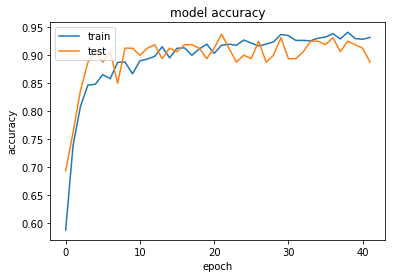

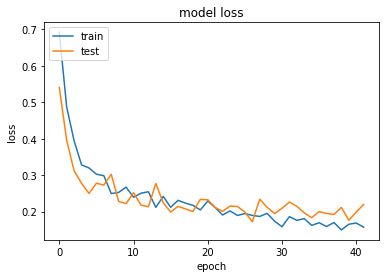

In [14]:
# list all data in history
print(histr.history.keys())
# summarize history for accuracy
plt.plot(histr.history['acc'])
plt.plot(histr.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histr.history['loss'])
plt.plot(histr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

---

In [15]:
import matplotlib.image as mpimg

min1 = np.min(X_holdout)
max1 = np.max(X_holdout)
diff1 = max1 - min1
my_sum = lambda x: (x - min1)/diff1

X_holdout2 = my_sum(X_holdout)

In [16]:
X_holdout2.shape

(160, 75, 75, 3)

In [17]:
Y_holdout

13      1
14      0
38      1
43      0
44      0
80      0
104     1
127     0
137     0
138     1
141     1
167     1
195     1
199     0
207     1
212     0
213     1
221     0
240     0
256     0
267     1
274     1
276     1
285     1
290     0
294     0
300     1
307     1
311     1
318     1
       ..
1363    1
1364    0
1373    1
1380    1
1394    0
1411    0
1435    0
1440    1
1445    1
1447    1
1460    1
1470    0
1488    0
1495    0
1504    1
1516    0
1525    0
1533    0
1537    0
1539    0
1541    0
1542    0
1549    0
1552    0
1559    0
1566    0
1567    0
1577    0
1590    0
1602    0
Name: is_iceberg, Length: 160, dtype: int64

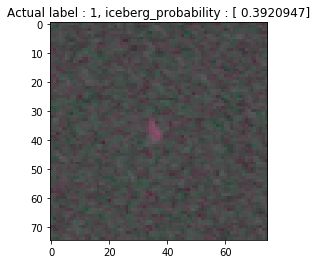

In [18]:
plt.imshow(X_holdout2[0], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[13])+ ","+" iceberg_probability : "+str(pred_valid[0])
plt.title(tl)

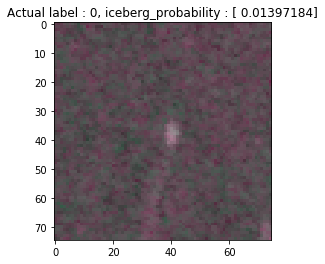

In [19]:
plt.imshow(X_holdout2[1], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[14])+ ","+" iceberg_probability : "+str(pred_valid[1])
plt.title(tl)

In [20]:
pred_valid.shape

(160, 1)

In [21]:
Y_holdout.shape

(160,)

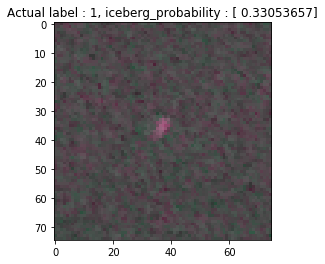

In [22]:
plt.imshow(X_holdout2[2], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[38])+ ","+" iceberg_probability : "+str(pred_valid[2])
plt.title(tl)

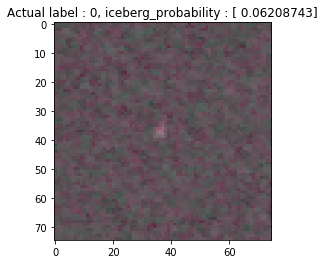

In [23]:
plt.imshow(X_holdout2[159], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[1602])+ ","+" iceberg_probability : "+str(pred_valid[159])
plt.title(tl)

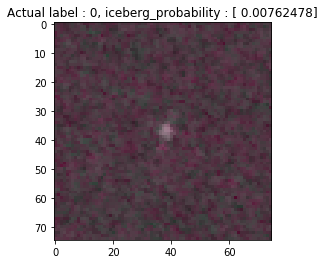

In [24]:
plt.imshow(X_holdout2[3], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[43])+ ","+" iceberg_probability : "+str(pred_valid[3])
plt.title(tl)

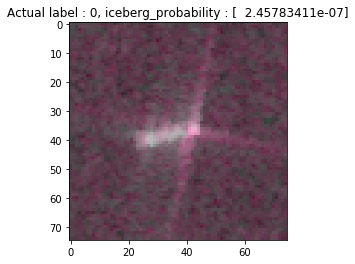

In [25]:
plt.imshow(X_holdout2[4], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[44])+ ","+" iceberg_probability : "+str(pred_valid[4])
plt.title(tl)

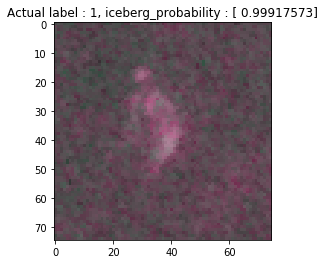

In [26]:
plt.imshow(X_holdout2[6], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[104])+ ","+" iceberg_probability : "+str(pred_valid[6])
plt.title(tl)

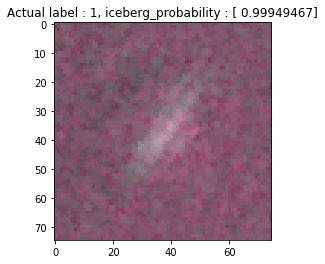

In [27]:
plt.imshow(X_holdout2[9], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[138])+ ","+" iceberg_probability : "+str(pred_valid[9])
plt.title(tl)